<a href="https://colab.research.google.com/github/saugatbh/RainfallDataAnalysis/blob/main/ComparisonLstmGruBi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pdb

import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from math import sqrt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
data = np.load('/content/drive/MyDrive/rainfall_data.npy')
data = np.where(data<0,0,data)
one_grid = data[:,:,64,74]
one_grid=one_grid.reshape([one_grid.shape[0] * one_grid.shape[1], 1])
one_grid = preprocessing.normalize(one_grid)

region = data[:, :, 63:66, 73:76]
region = region.reshape([region.shape[0] * region.shape[1], 9])
region=preprocessing.normalize(region)

In [3]:
n = region.shape[0]
train_data = region[0:int(n*0.7)]
val_data = region[int(n*0.7):int(n*0.9)]
test_data = region[int(n*0.9):]

In [4]:
print("train.shape,val.shape,test.shape: ", train_data.shape, val_data.shape, test_data.shape)

train.shape,val.shape,test.shape:  (965, 9) (277, 9) (138, 9)


In [5]:
# generate windows of data for the model
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=val_data, test_df=test_data):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}'])

In [6]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [7]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [8]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [9]:
def plot(self, name,model=None, max_subplots=3):
  # pdb.set_trace()
  inputs, labels = self.example
  print("len(inputs): ",len(inputs))
  print("len(labels): ",len(labels))
  plt.figure(figsize=(12, 8))
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'Actual Value')
    plt.plot(self.input_indices, inputs[n, :, 0],
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(self.label_indices, labels[n, :,0],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, 0],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')
  print("RMSE( ",name," ) = ",sqrt(mean_squared_error(labels[:,:,0],inputs[:,:,0])))

WindowGenerator.plot = plot

In [10]:
def plot_loss (history, model_name):
    plt.figure(figsize = (12, 8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

In [11]:
# create a model with an LSTM
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [12]:
# Create BiLSTM model
bilstm_model = tf.keras.models.Sequential([
                                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                           tf.keras.layers.Dense(36*1),
                                           tf.keras.layers.Reshape([36, 1])
])

In [13]:
gru_model = tf.keras.models.Sequential([
                                        tf.keras.layers.GRU(32,return_sequences=True),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.GRU(32),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(36*1),
                                        tf.keras.layers.Reshape([36,1])
])

In [14]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [15]:
w1_wide = WindowGenerator(input_width=36, label_width=36, shift=1)
w1_wide

Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]

In [16]:
print('Input shape:', w1_wide.example[0].shape)
print('Output shape(lstm_model):', lstm_model(w1_wide.example[0]).shape)
print('Output shape(bilstm_model):', bilstm_model(w1_wide.example[0]).shape)
print('Output shape(gru_model):', gru_model(w1_wide.example[0]).shape)

Input shape: (32, 36, 9)
Output shape(lstm_model): (32, 36, 1)
Output shape(bilstm_model): (32, 36, 1)
Output shape(gru_model): (32, 36, 1)


8/8 [==============================] - 0s 6ms/step - loss: 0.0303 - mean_absolute_error: 0.1326
[0.030269267037510872, 0.13256217539310455]
4/4 [==============================] - 0s 7ms/step - loss: 0.0238 - mean_absolute_error: 0.1175
[0.02382657118141651, 0.11754531413316727]
(102, 36, 1)
len(inputs):  32
len(labels):  32
RMSE(  lstm  ) =  0.18691581876720897


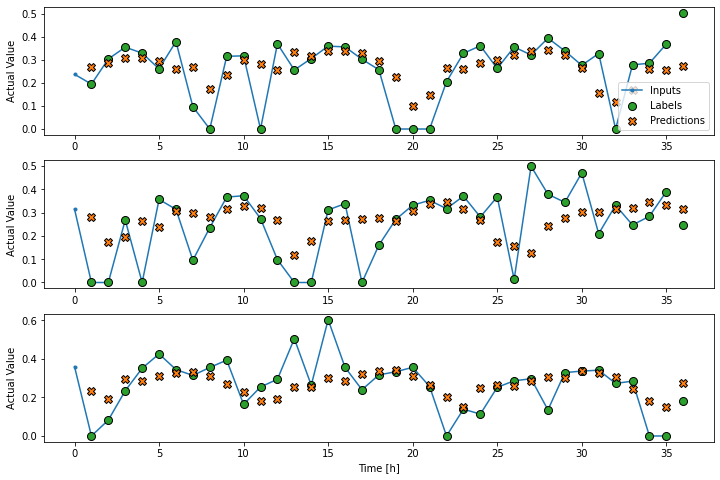

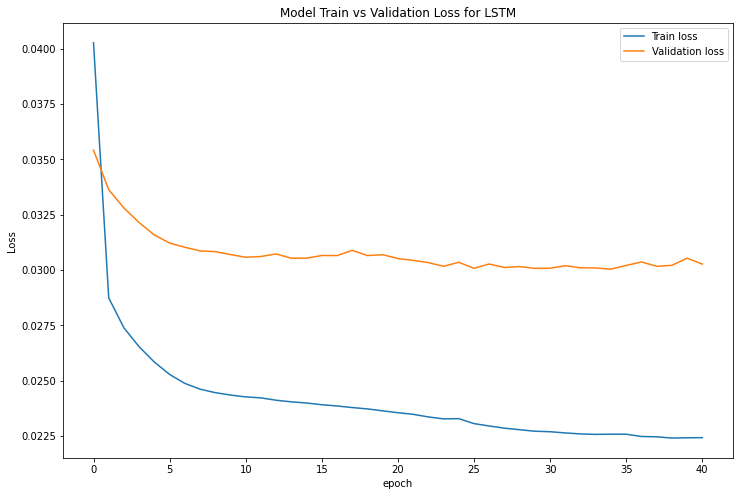

In [17]:
historylstm = compile_and_fit(lstm_model, w1_wide)
IPython.display.clear_output()
print(lstm_model.evaluate(w1_wide.val))
print(lstm_model.evaluate(w1_wide.test))
print((lstm_model.predict(w1_wide.test)).shape)
w1_wide.plot("lstm",lstm_model)
plot_loss (historylstm, 'LSTM')

8/8 [==============================] - 0s 10ms/step - loss: 0.0278 - mean_absolute_error: 0.1240
[0.02775663137435913, 0.12397410720586777]
4/4 [==============================] - 0s 10ms/step - loss: 0.0218 - mean_absolute_error: 0.1118
[0.021789059042930603, 0.11175687611103058]
(102, 36, 1)
len(inputs):  32
len(labels):  32
RMSE(  bilstm  ) =  0.18691581876720897


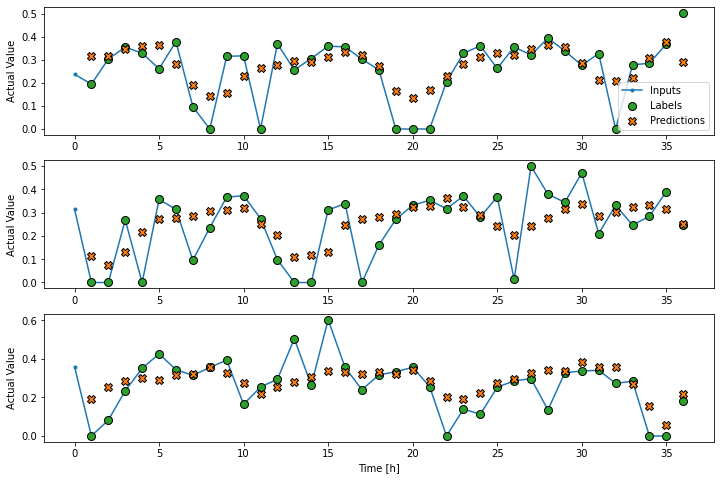

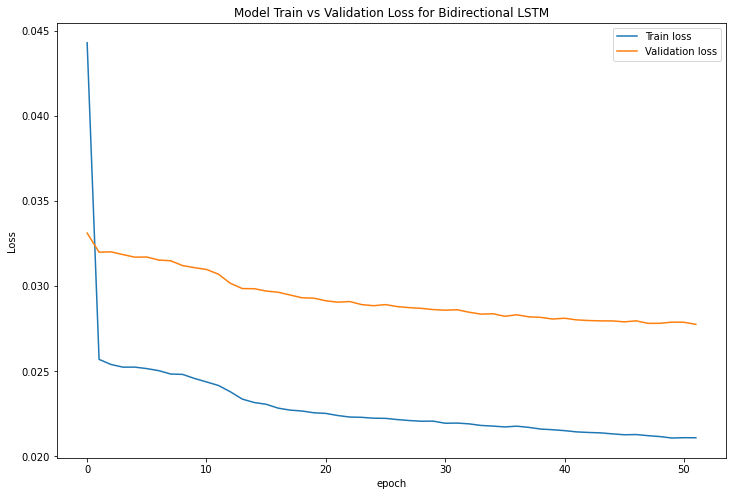

In [18]:
historybilstm = compile_and_fit(bilstm_model,w1_wide)
IPython.display.clear_output()
print(bilstm_model.evaluate(w1_wide.val))
print(bilstm_model.evaluate(w1_wide.test))
print((bilstm_model.predict(w1_wide.test)).shape)
w1_wide.plot("bilstm",bilstm_model)
plot_loss (historybilstm, 'Bidirectional LSTM')

8/8 [==============================] - 0s 7ms/step - loss: 0.0292 - mean_absolute_error: 0.1293
[0.029176484793424606, 0.12933889031410217]
4/4 [==============================] - 0s 8ms/step - loss: 0.0237 - mean_absolute_error: 0.1177
[0.023695258423686028, 0.11774902045726776]
(102, 36, 1)
len(inputs):  32
len(labels):  32
RMSE(  gru  ) =  0.18691581876720897


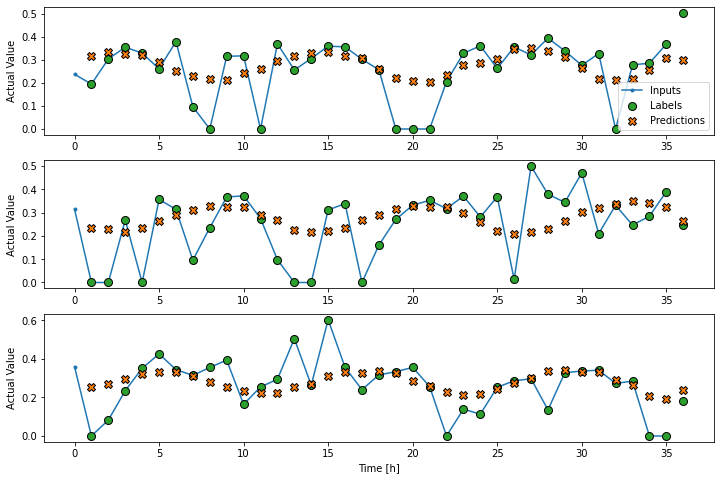

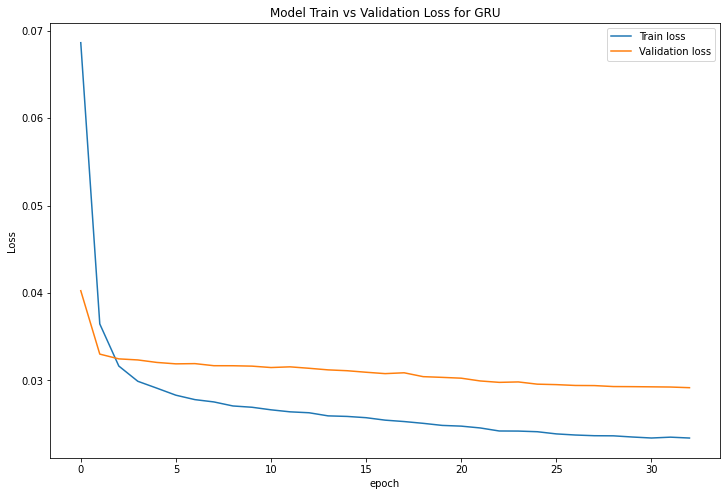

In [19]:
historygru = compile_and_fit(gru_model,w1_wide)
IPython.display.clear_output()
print(gru_model.evaluate(w1_wide.val))
print(gru_model.evaluate(w1_wide.test))
print((gru_model.predict(w1_wide.test)).shape)
w1_wide.plot("gru",gru_model)
plot_loss (historygru, 'GRU')